# Post-sampling correction

Small values of the threshold parameter $\epsilon$ produce more accurate approximations of the posterior distribution. However, this comes at a computational cost as the acceptance probability is consequently also reduced. One approach to remedy this problem is to fit regression models to estimate the approximate posterior with $\epsilon = 0$. This is discussed in more detail in [*Lintusaari et al 2016*](https://doi.org/10.1093/sysbio/syw077) *[1]* and [*Beaumont et al 2002*](http://www.genetics.org/content/162/4/2025) *[2]*.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as ss

from functools import partial

import elfi
from elfi.examples import gauss

We will use a simple model of a univariate Gaussian with an unknown mean to illustrate posterior adjustment. The observed data is 50 data points sampled from a Gaussian distribution with mean 5 and a standard deviation of one. Since we use a Gaussian prior for the mean, the posterior is also Gaussian with known parameters.

In [2]:
m = gauss.get_model()

seed = 20170616
n_obs = 50
batch_size = 100
mu, sigma = (5, 1)

y_obs = gauss.Gauss(mu, sigma, n_obs=n_obs, batch_size=1,
                random_state=np.random.RandomState(seed))

# Hyperparameters
mu0, sigma0 = (7, 100)

# Posterior parameters
n = y_obs.shape[1]
mu1 = (mu0/sigma0**2 + y_obs.sum()/sigma**2)/(1/sigma0**2 + n/sigma**2)
sigma1 = (1/sigma0**2 + n/sigma**2)**(-0.5)

We use a normal distribution with a large standard deviation $\sigma = 100$ and a non-centered mean $\mu = 7$ as an uninformative prior for the unknown mean. A large acceptance radius of $\epsilon = 1$ does not produce very accurate results.

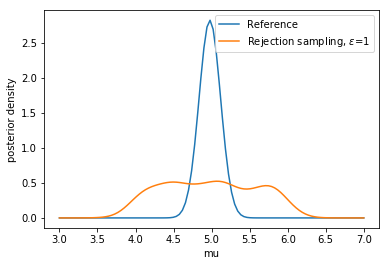

In [3]:
# Model
m = elfi.ElfiModel(set_current=False)
sim_fn = partial(gauss.Gauss, sigma=sigma, n_obs=n_obs)
elfi.Prior('norm', mu0, sigma0, model=m, name='mu')
elfi.Simulator(sim_fn, m['mu'], observed=y_obs, name='Gauss')
elfi.Summary(lambda x: x.mean(axis=1), m['Gauss'], name='S1')
elfi.Distance('euclidean', m['S1'], name='d')

res = elfi.Rejection(m['d'], outputs=['S1'], batch_size=batch_size, seed=seed).sample(1000, threshold=1)
original = res.outputs['mu']
original = original[np.isfinite(original)] # omit non-finite values

# Kernel density estimate for visualization
kde = ss.gaussian_kde(original)

plt.figure()
t = np.linspace(3, 7, 100)
plt.plot(t, ss.norm(loc=mu1, scale=sigma1).pdf(t))
plt.plot(t, kde.pdf(t))
plt.legend(['Reference', 'Rejection sampling, $\epsilon$=1'])
plt.xlabel('mu')
plt.ylabel('posterior density');

By regressing on the differences between the sampled and observed summary statistics, we attempt to correct the posterior sample with a linear model. The posterior adjustment is done with the `adjust_posterior` function. It takes as arguments the inference model, the results from an ABC algorithm, the parameter names and the names of the summary statistics.
Other regression models, instead of a linear one, can be specified with the `adjustment` keyword argument.

In [4]:
adj = elfi.adjust_posterior(m, res, ['mu'], ['S1'], adjustment=elfi.LinearAdjustment())

Similarly to other ABC algorithms in ELFI, post-processing produces a `Result` object. As can be seen, the linear correction improves the posterior approximation of this model compared to rejection sampling alone.

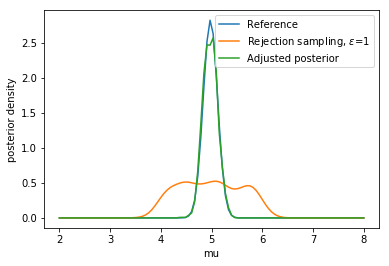

In [5]:
kde_adj = ss.gaussian_kde(adj.outputs['mu'])

plt.figure()
t = np.linspace(2, 8, 100)
plt.plot(t, ss.norm(loc=mu1, scale=sigma1).pdf(t))
plt.plot(t, kde.pdf(t))
plt.plot(t, kde_adj(t))
plt.legend(['Reference', 'Rejection sampling, $\epsilon$=1', 'Adjusted posterior'])
plt.xlabel('mu')
plt.ylabel('posterior density');

# Multiple parameters

Posterior adjustment can also be used with models having multiple parameters. In this case, each scalar parameter has their own regression model that is used to adjust them. Non-scalar parameters are not supported.

To illustrate multiple parameter models, we use the moving average model contained in the examples folder. Ww use the values $t_1 = 0.6$ and $t_2 = 0.2$ to generate the data.

In [6]:
from elfi.examples import ma2

seed = 20170511
threshold = 0.2
batch_size = 1000
n_samples = 500

m2 = ma2.get_model(n_obs=100, true_params=[0.6, 0.2], seed_obs=seed)
rej2 = elfi.Rejection(m2, m2['d'], outputs=['S1', 'S2'], batch_size=batch_size, seed=seed)
res2 = rej2.sample(n_samples, threshold=threshold)

adj2 = elfi.adjust_posterior(m2, res2, ['t1', 't2'], ['S1', 'S2'])

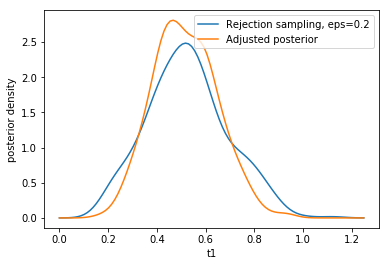

In [7]:
plt.figure()
t = np.linspace(0, 1.25, 100)
plt.plot(t, ss.gaussian_kde(res2.outputs['t1'])(t))
plt.plot(t, ss.gaussian_kde(adj2.outputs['t1'])(t))
plt.legend(['Rejection sampling, eps=0.2', 'Adjusted posterior'])
plt.xlabel('t1')
plt.ylabel('posterior density');

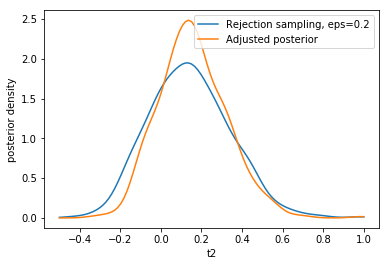

In [8]:
plt.figure()
t = np.linspace(-0.5, 1, 100)
plt.plot(t, ss.gaussian_kde(res2.outputs['t2'])(t))
plt.plot(t, ss.gaussian_kde(adj2.outputs['t2'])(t))
plt.legend(['Rejection sampling, eps=0.2', 'Adjusted posterior'])
plt.xlabel('t2')
plt.ylabel('posterior density');

# References

- [1] Jarno Lintusaari, Michael U. Gutmann, Ritabrata Dutta, Samuel Kaski, Jukka Corander; Fundamentals and Recent Developments in Approximate Bayesian Computation. Syst Biol 2017; 66 (1): e66-e82. doi: 10.1093/sysbio/syw077
- [2] Beaumont M.A., Zhang W., Balding, D.J. 2002. Approximate Bayesian computation in population genetics. Genetics 162:2025–2035